# Algorithmic Fairness, Accountability and Ethics
## Assignment 2
Kamil Kojs, Janos Mate, Jorge del Pozo

In [205]:
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, matthews_corrcoef, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import scipy.optimize as opt
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.decomposition import PCA
from numpy.testing import assert_array_almost_equal
import scipy
from scipy.optimize import fmin_tnc
import math

try:
    import seaborn as sns
    sns.set()
except:
    print("Run without Seaborn")


### 1. Load and Preprocess the data
We are going to work with the [Folktables](https://github.com/socialfoundations/folktables#quick-start-examples) dataset (*you have already worked with it*).

1. As last week, we are still predicting the *Total person's income*  (I've digitized  it in  `target_transform=lambda x: x > 25000`).
2. Today, we are going to implement two methods for data debiasing: [Fair PCA](https://deepai.org/publication/efficient-fair-pca-for-fair-representation-learning) and [A Geometric Solution to Fair Representations](https://dl.acm.org/doi/10.1145/3375627.3375864).
3. We are going to evaluate the performance on two sensitive features: `SEX` (i.e. *Males* and *Females*) and `RAC1P` (we will consider only *Whites* and *African-Americans*)
4. I updated the filtering method `adult_filter` to keep the specified groups.

In [32]:
data_source = ACSDataSource(
    survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
mm_scalar = MinMaxScaler()


def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3]  # keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'CIT',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P'
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,
    group=['SEX', "RAC1P"],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)


## Task 1 - Bias Analysis

In [33]:
######
# YOUR CODE
#####


## Task 2 - Model & Data Debiasing
Now we are going to train a model to predict the income of a person based on the attributes we have
at hand. We want to have a model with the high predictive performance, but we also want to make
sure that our model does not discriminate against any protected groups.

### Task 2.1.: Data
1. Convert categorical to one-hot encoding.
2. Remove redundant categorical columns (as you have done in Lecture 6).
3. Remove protected attributes from the data (keep it aside).
4. Split data into Training and Test sets.

In [38]:
definition_df = data_source.get_definitions(download=True)
categories = generate_categories(
    features=ACSIncomeNew.features, definition_df=definition_df)

# 1- Convert categroical to one-hot encoding
features, labels, groups = ACSIncomeNew.df_to_pandas(
    acs_data, categories=categories, dummies=True)
# groups now contain information about SEX and RAC1P
features.head()


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,SEX_Male,RAC1P_Black or African American alone,RAC1P_White alone
0,21.0,20.0,52.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
1,65.0,8.0,33.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
2,33.0,40.0,53.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
3,18.0,18.0,106.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,27.0,50.0,23.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


In [39]:
# 2 - Drop the "redundant" columns
features = features.drop(["RELP_Unmarried partner",
                          "CIT_U.S. citizen by naturalization",
                          "SEX_Male",
                          "SCHL_1 or more years of college credit, no degree",
                          "MAR_Divorced",
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm',
                          "RAC1P_White alone"], axis=1)

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" % i, "(%s)" % f)


Columns with the protected features:
Column ID: 57 (SEX_Female)
Column ID: 58 (RAC1P_Black or African American alone)


In [40]:
# 3 - Drop protected features from features
protected = [
    "SEX_Female",
    "RAC1P_Black or African American alone"
]
if protected[0] in features.columns.to_list() or protected[1] in features.columns.to_list():
    features = features.drop(protected, axis=1)
else:
    print("No protected features present already")


In [85]:
# Normalize numeric features in a different dataframe (used for PCA)
def scale_columns(data, columns=["AGEP", "WKHP", "PWGTP"], scaler=MinMaxScaler()):

    for column in columns:
        data[column] = scaler.fit_transform(
            np.array(data[column]).reshape(-1, 1))

    return data


features_normalized = features.copy()
features_normalized = scale_columns(features_normalized)


In [86]:
features_normalized.head()


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Husband/wife,RELP_Institutionalized group quarters population,RELP_Noninstitutionalized group quarters population,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter
0,0.051948,0.193878,0.036299,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.623377,0.071429,0.022776,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.207792,0.397959,0.037011,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.012987,0.173469,0.074733,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.129870,0.500000,0.015658,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [147]:
# 4- . Split data into Training and Test sets (used for PCA)
def split_dataset(features, labels, groups, N=20000):

    X_train, X_test, y_train, y_test, group_train, group_test = train_test_split(
        features.values, labels.values.reshape(-1), groups, test_size=0.3, random_state=0, shuffle=True)

    N = 20000  # Subsampling due to speed

    X_train = X_train[:N]
    y_train = y_train[:N]
    group_train = group_train[:N]
    X_test = X_test[:N]
    y_test = y_test[:N]
    group_test = group_test[:N]

    return X_train, X_test, y_train, y_test, group_train, group_test


# Split already normalized dataset
X_train, X_test, y_train, y_test, group_train, group_test = split_dataset(
    features_normalized, labels, groups, N=20000)


#### Task 2.2 - Baseline Model
Use the following arguments in the `opt.fmin_funct`: `xtol=1e-4, ftol=1e-4,  maxfun=1000`

#### Part1: Build your own implementation of the Logistic Regression with L2-penalty (aka Ridge Regression).

In [175]:
# Define necessary functions for custom implementation

def sigmoid(beta_x, eps=1e-10):
    """
    This is logistic regression
    f = 1/(1+exp(-beta^T * x))
    This function assumes as input that you have already multiplied beta and X together
    """
    return 1/(1 + np.exp(-beta_x + eps))


def logistic_loss(y_true, y_pred, eps=1e-10):
    """
    Loss for the logistic regression, y_preds are probabilities
    eps: epsilon for stability
    """
    summand_1 = y_true * np.log(y_pred + eps)
    summand_2 = (1-y_true) * np.log(1 - y_pred + eps)

    return -np.mean(summand_1 + summand_2)


def l2_loss(beta):
    """
    L2-Regularisation
    """
    return sum(beta**2)


def fair_loss(y, y_pred, groups):
    """
    Group fairness Loss

    y_pred: sigmoid(βTx)
    y: prediction in 0 or 1
    groups: dataframe with column for each protected variable
    """

    cum_result = 0

    for p_group in groups.columns.to_list():

        group = groups[p_group].to_numpy()

        y_g1 = y[group == 1]
        y_pred_g1 = y_pred[group == 1]
        y_g2 = y[group == 2]
        y_pred_g2 = y_pred[group == 2]

        n1 = np.sum(group == 1)
        n2 = np.sum(group == 2)

        # Compute pair-wise
        # all pairwise equalities between y_g1 and y_g2
        distance = np.equal.outer(y_g1, y_g2).astype(int)
        # all pairwise differences between y_pred_g1 and y_pred_g2
        diff = np.subtract.outer(y_pred_g1, y_pred_g2)
        diff_squared = (diff)**2  # square the differenes

        cost = np.sum(distance * diff_squared)  # multiply both

        result = (cost/(n1*n2))  # result for this protected variable

        cum_result += result  # combined result for all proetected variables

    return cum_result


def compute_gradient_withl2(beta, X, y, groups, _lambda, _gamma):
    """Calculate the gradient - used for finding the best beta values. 
       You do not need to use groups and lambda (fmin_tnc expects same input as 
       in func, that's why they are included here)

       Note: we do not include fairness constrint here
       """

    grad = np.zeros(beta.shape)
    y_pred = sigmoid(X.dot(beta))
    diff = y_pred - y
    m = beta.shape

    # Loop over features and correponding weights and calcualte gradient for each
    for j in range(len(grad)):
        if j == 0:
            # we do not want to regularize the intercept
            grad[j] = np.dot(diff, X[:, j])/m
        else:
            grad[j] = np.dot(diff, X[:, j])/m + 2*beta[j]*_gamma

    return grad


def compute_cost_withl2(beta, X, y, groups, _lambda, _gamma):
    """Computes cost function with constraints"""

    # Logistic function prediction and real value, all in numeric
    y_pred = sigmoid(X.dot(beta))
    y_real = np.array(y).astype(int)

    # Calculate each loss and add up
    loss_log = logistic_loss(y_real, y_pred, eps=1e-10)
    loss_l2 = _gamma * l2_loss(beta[1:])  # l2 loss does not consider intercept

    loss = loss_log + \
        loss_l2

    return loss


def compute_cost_withl2_withfairness(beta, X, y, groups, _lambda, _gamma):
    """Computes cost function with constraints"""

    # Logistic function prediction and real value, all in numeric
    y_pred = sigmoid(X.dot(beta))
    y_real = np.array(y).astype(int)

    # Calculate each loss and add up
    loss_log = logistic_loss(y_real, y_pred, eps=1e-10)
    loss_fair = _lambda * fair_loss(y_real, y_pred, groups)
    loss_l2 = _gamma * l2_loss(beta[1:])  # l2 loss does not consider intercept

    loss = loss_log + \
        loss_fair + \
        loss_l2

    # print('log',round(loss_log, 4),'fair', round(loss_fair,4),'l2', round(loss_l2,4), 'TOTAL:', round(loss,4))

    return loss


def fit_logistic_l2(X, y, groups, lambda_used, include_fairness=False):
    '''
    Function that finds optimal weights for given input

    X: numpy array with features
    y: numpy array with labels
    groups: pandas dataframe with protected groups

    '''

    betas = np.random.rand(X.shape[1])

    if include_fairness:
        cost_func = compute_cost_withl2_withfairness
    else:
        cost_func = compute_cost_withl2

    new_weights, q, code = opt.fmin_tnc(func=cost_func, x0=betas, messages=0,  fprime=compute_gradient_withl2, maxfun=500,
                                        args=(X, y, groups, lambda_used, 1e-5), xtol=1e-7, ftol=1e-5)
    return new_weights


def perform_crossvalidation(X, y, groups, l2_penalty_values, n_folds=5, include_fairness=False):

    kf = KFold(n_splits=n_folds, shuffle=True)
    scaler = MinMaxScaler()

    validation_scores = []

    # Calculate score for each possible value and store
    for l2_penalty in l2_penalty_values:
        print(f"Checking value: {l2_penalty}")
        scores = []

        for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X)):
            # split the data into training and validation sets
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            groups_train, groups_val = groups.iloc[train_idx], groups.iloc[val_idx]

            # normalize the data using the training set and apply the same transformation to the validation set
            scaler.fit(X_train)
            X_train_norm = scaler.transform(X_train)
            X_val_norm = scaler.transform(X_val)

            # Fit custom model
            weights = fit_logistic_l2(X_train_norm, y_train, groups_train,
                                      lambda_used=l2_penalty, include_fairness=include_fairness)
            prob = sigmoid(X_val_norm.dot(weights))
            y_pred = (prob >= 0.5).astype(int)

            score = np.mean(y_pred == y_val)

            scores.append(score)
            
        mean_score = np.mean(scores)
        print(f"--->mean score: {mean_score}")

        validation_scores.append(mean_score)

    optimal_l2_penalty = l2_penalty_values[np.argmax(validation_scores)]

    return optimal_l2_penalty, validation_scores


#### Part2: Use Cross-Validation to find the most optimal value for L2-penalty (you should implement it yourself).

In [178]:
# Sample dataframes
sampled_rows = features.sample(n=20000, random_state=0).index
features_sampled = features.loc[sampled_rows]
groups_sampled = groups.loc[sampled_rows]
labels_sampled = labels.loc[sampled_rows]

# Add column to features for intercept
features_sampled = features_sampled.insert(0, 'intercept', 1)

# Define search space of lambdas
lambdas = np.linspace(1, 1e-5, 10) 

# 2- Perform crossvalidation and get best lambda
optimal_l2_penalty, validation_scores = perform_crossvalidation(
    features.values, labels.values.reshape(-1), groups, lambdas, n_folds=5)


Checking value: 1.0
0.8200875416036659
Checking value: 0.88889
0.8203422093380673
Checking value: 0.77778
0.8202727690694468
Checking value: 0.66667
0.8201801380607089
Checking value: 0.55556
0.8203036454766405
Checking value: 0.44445
0.8203884975882977
Checking value: 0.33333999999999997
0.8201724294584558
Checking value: 0.22223000000000004
0.8199948802132655
Checking value: 0.11112
0.8201492804186596
Checking value: 1e-05
0.8202882047412384


In [179]:
optimal_l2_penalty

0.44445

#### Part 3 - Evaluate the overall performance of the final model on the Test Set (use an appropriate metrics) + report uncertainty.

In [200]:
# Define necessary functions

def evaluate_performance(y_true, y_pred):
    TP = np.sum(np.logical_and(y_true == 1, y_pred == 1))
    FP = np.sum(np.logical_and(y_true == 0, y_pred == 1))
    FN = np.sum(np.logical_and(y_true == 1, y_pred == 0))
    TN = np.sum(np.logical_and(y_true == 0, y_pred == 0))

    # calculate recall, precision, and accuracy
    recall = TP / (TP + FN)
    precision = TP / (TP + FP)
    accuracy = (TP + TN) / (TP + TN + FP + FN)

    # calculate F1 score
    F1 = 2 * precision * recall / (precision + recall)

    return recall, precision, accuracy, F1

def plot_confusion_matrix(y_true, y_pred):
    
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    labels = np.unique(y_true)
    fig, ax = plt.subplots()
    ax = sns.heatmap(cm, annot=True, cmap='Blues', cbar=False,
                     xticklabels=labels, yticklabels=labels, square=True)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion matrix')

    return fig, ax


def plot_scores(recall, precision, accuracy, f1):
    scores = [recall, precision, accuracy, f1]
    labels = ['Recall', 'Precision', 'Accuracy', 'F1']
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots()
    rects = ax.bar(x, scores, width)
    
    ax.set_ylabel('Score')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')
    
    autolabel(rects)
    plt.show()

In [201]:
# Fit model to our data

lambda_used = optimal_l2_penalty
weights = fit_logistic_l2(np.insert(X_train, 0, 1, axis=1), y_train, group_train,
                            lambda_used=lambda_used, include_fairness=False)
prob = sigmoid(np.insert(X_test, 0, 1, axis=1).dot(weights))
y_pred = (prob >= 0.5).astype(int)



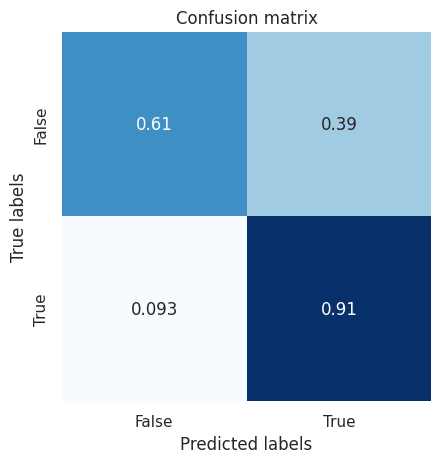

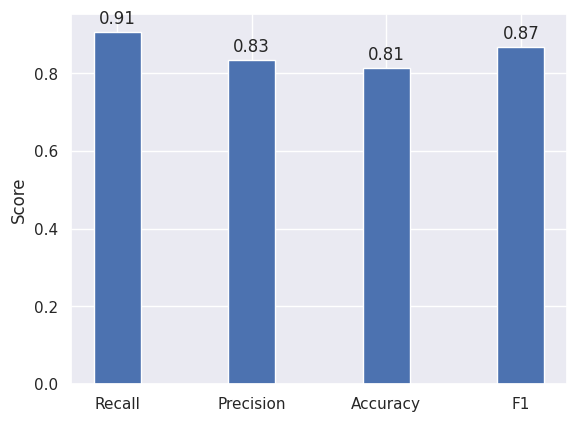

In [202]:
# Calculate metrics and plot
recall, precision, accuracy, F1 = evaluate_performance(y_test, y_pred)
fig, ax = plot_confusion_matrix(y_test, y_pred)
plot_scores(recall, precision, accuracy, F1)

#### 4. Look at the fairness metric associated with each SEX and RAC1P groups. Are there any discrepancies?

### Task 2.3
Use the following arguments in the `opt.fmin_funct`: ` xtol=1e-3, ftol=1e-3, approx_grad=True, maxfun=1000`

### Task 2.4.: Fair PCA

#### Part 1

In [50]:
# protected columns already dropped in features_normalized so no need to substract 4 for PCA column count
n_components = len(features_normalized.columns)
print(n_components)

pca = PCA(n_components=n_components)  # create a PCA object
X = pca.fit_transform(features_normalized)  # do the math

pca_columns = []
for i in range(n_components):
    pca_columns.append(f"PC{i}")


57


In [51]:
pca_no_protected = pd.DataFrame(X, columns=pca_columns)
pca_no_protected


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56
0,0.857620,0.145218,0.787893,0.519411,-0.261277,0.643628,-0.167002,-0.281697,-0.239785,0.201850,...,0.006804,0.008526,0.001325,0.005695,0.001414,0.001657,-0.003357,0.000234,0.000594,-0.000159
1,0.629727,-0.105494,0.996165,0.381739,-0.091806,-0.534873,-0.652221,-0.520471,0.191448,0.700450,...,0.003831,0.002748,-0.000727,0.001335,-0.001629,0.000094,-0.002314,0.000729,0.000346,0.000058
2,0.365926,0.319524,-0.160967,-0.094486,-0.231605,-0.211054,0.138521,-0.093186,-0.038699,-0.075907,...,0.002495,0.003416,0.001626,0.001786,0.006991,0.001455,-0.000126,0.000134,0.000472,-0.001192
3,0.779174,0.003180,0.942548,0.261743,0.049367,-0.196561,-0.100012,-0.217842,-0.134768,0.836081,...,-0.007821,-0.007527,-0.002323,-0.004168,0.002257,-0.001688,-0.001632,-0.000992,-0.000601,-0.000141
4,0.736888,-0.076281,0.915497,-0.448166,0.551926,0.155626,-0.068356,-0.244956,-0.185974,0.129219,...,0.005730,0.006106,-0.002029,0.003071,0.003097,0.001314,-0.004400,0.000668,0.000530,0.000188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129558,0.418755,-0.701246,0.113548,1.151621,1.049752,-0.035615,0.474293,-0.445882,0.230799,-0.251701,...,0.001080,-0.000253,0.003186,-0.000865,0.000217,-0.000915,-0.002438,0.000400,-0.000078,0.000095
129559,0.784121,0.454849,-0.502301,0.728732,0.939379,-0.285873,-0.027390,-0.224300,-0.140164,-0.027469,...,-0.001670,-0.002154,0.000547,-0.002524,0.001275,-0.002312,-0.000526,0.000411,-0.001111,0.000157
129560,-0.507927,-0.268378,-0.912778,0.330463,0.256196,-0.127873,0.016784,0.204874,0.085388,0.023580,...,0.011386,0.014455,-0.009579,0.007790,-0.003352,0.002858,-0.000385,0.000063,0.000568,-0.000007
129561,-0.544838,0.037109,0.659249,0.241832,-0.118356,0.070566,0.576689,-0.092703,0.490673,-0.219828,...,-0.012097,-0.013359,-0.001872,-0.011070,0.000533,-0.002602,0.002825,-0.002184,-0.002157,0.000341


In [52]:
task_1_merged = pd.concat([pca_no_protected, groups], axis=1)
task_1_merged


,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,SEX,RAC1P
0,0.857620,0.145218,0.787893,0.519411,-0.261277,0.643628,-0.167002,-0.281697,-0.239785,0.201850,...,0.001325,0.005695,0.001414,0.001657,-0.003357,0.000234,0.000594,-0.000159,1,1
1,0.629727,-0.105494,0.996165,0.381739,-0.091806,-0.534873,-0.652221,-0.520471,0.191448,0.700450,...,-0.000727,0.001335,-0.001629,0.000094,-0.002314,0.000729,0.000346,0.000058,1,1
2,0.365926,0.319524,-0.160967,-0.094486,-0.231605,-0.211054,0.138521,-0.093186,-0.038699,-0.075907,...,0.001626,0.001786,0.006991,0.001455,-0.000126,0.000134,0.000472,-0.001192,1,1
3,0.779174,0.003180,0.942548,0.261743,0.049367,-0.196561,-0.100012,-0.217842,-0.134768,0.836081,...,-0.002323,-0.004168,0.002257,-0.001688,-0.001632,-0.000992,-0.000601,-0.000141,2,1
4,0.736888,-0.076281,0.915497,-0.448166,0.551926,0.155626,-0.068356,-0.244956,-0.185974,0.129219,...,-0.002029,0.003071,0.003097,0.001314,-0.004400,0.000668,0.000530,0.000188,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129558,0.418755,-0.701246,0.113548,1.151621,1.049752,-0.035615,0.474293,-0.445882,0.230799,-0.251701,...,0.003186,-0.000865,0.000217,-0.000915,-0.002438,0.000400,-0.000078,0.000095,1,1
129559,0.784121,0.454849,-0.502301,0.728732,0.939379,-0.285873,-0.027390,-0.224300,-0.140164,-0.027469,...,0.000547,-0.002524,0.001275,-0.002312,-0.000526,0.000411,-0.001111,0.000157,2,1
129560,-0.507927,-0.268378,-0.912778,0.330463,0.256196,-0.127873,0.016784,0.204874,0.085388,0.023580,...,-0.009579,0.007790,-0.003352,0.002858,-0.000385,0.000063,0.000568,-0.000007,1,1
129561,-0.544838,0.037109,0.659249,0.241832,-0.118356,0.070566,0.576689,-0.092703,0.490673,-0.219828,...,-0.001872,-0.011070,0.000533,-0.002602,0.002825,-0.002184,-0.002157,0.000341,1,1


In [54]:
import pandas as pd
from scipy.stats import pearsonr
n_features = X_train.shape[1]
alpha = 0.05  # significance level
# Bonferroni correction for multiple testings
corrected_alpha = alpha / (n_features**2/2)

##############################
# Your code here
##############################


def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = float(round(pearsonr(tmp[r], tmp[c])[1], 4))
    return pvalues


In [55]:
p_values = calculate_pvalues(task_1_merged)
p_values = p_values.astype('float')


In [56]:
def heatmap_filtered_relevant(df, p_values, corrected_alpha, title):
    sns.heatmap(df, annot=False, cmap='rocket', linewidths=0.5,
                linecolor='black', mask=p_values > corrected_alpha)
    plt.title(title, fontsize=24)
    plt.tick_params(axis='both', which='both', labelsize=12)
    plt.tight_layout()


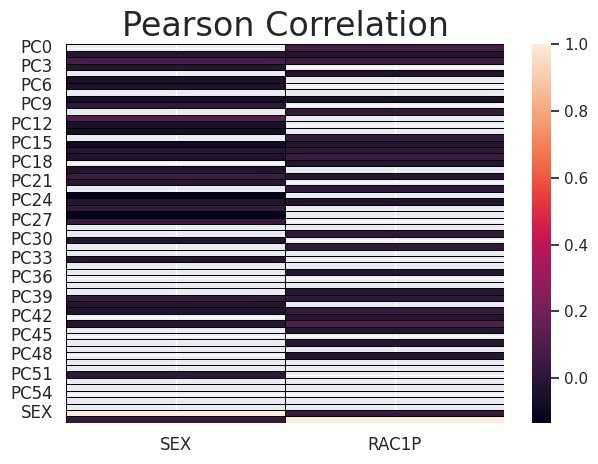

In [57]:
heatmap_filtered_relevant(task_1_merged.corr(method='pearson')[
                          ['SEX', 'RAC1P']], p_values[['SEX', 'RAC1P']], corrected_alpha, 'Pearson Correlation')


#### Part2

In [58]:
n_components = len(X_test[0])
print(n_components)

pca = PCA(n_components=n_components)  # create a PCA object
X_test_pca = pca.fit_transform(X_test)  # do the math

# project back
X_test_pca_proj_back = pca.inverse_transform(X_test_pca)
rec_errors = X_test - X_test_pca_proj_back


57


In [59]:
rec_errors_pd = pd.DataFrame(rec_errors, columns=features_normalized.columns)
rec_errors_pd


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Husband/wife,RELP_Institutionalized group quarters population,RELP_Noninstitutionalized group quarters population,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter
0,-6.661338e-16,2.220446e-16,-2.914335e-16,-2.220446e-16,-8.326673e-17,1.037365e-15,1.942890e-15,-9.714451e-17,1.901257e-15,-6.661338e-16,...,-8.104628e-15,-2.489328e-16,1.221245e-15,-3.278627e-16,-3.469447e-16,-1.572093e-17,1.110223e-15,1.543904e-16,1.873501e-16,-1.457168e-16
1,1.026956e-15,-1.332268e-15,2.775558e-16,-2.220446e-16,-1.179612e-15,2.109424e-15,9.436896e-16,-3.122502e-16,-5.828671e-15,3.747003e-16,...,3.885781e-16,1.214306e-17,1.186551e-15,-4.284767e-16,-1.474515e-16,-8.782038e-18,3.441691e-15,-1.925543e-16,5.030698e-17,-8.153200e-16
2,-4.163336e-16,-5.551115e-17,7.008283e-16,-3.219647e-15,1.165734e-15,-1.006140e-16,7.771561e-16,-2.220446e-16,3.330669e-16,6.245005e-16,...,1.415534e-15,6.158268e-17,1.165734e-15,-4.718448e-16,-2.792905e-16,6.559423e-17,-7.771561e-16,-4.354156e-16,1.561251e-16,-3.382711e-16
3,4.996004e-16,1.110223e-16,-2.775558e-17,-4.662937e-15,-8.743006e-16,1.387779e-15,-4.302114e-16,-8.118506e-16,2.012279e-15,-6.036838e-16,...,-1.665335e-16,-8.066464e-17,1.561251e-16,1.283695e-16,-5.551115e-17,6.071532e-18,0.000000e+00,-1.387779e-16,-1.838807e-16,-2.688821e-17
4,2.775558e-16,-2.220446e-16,-2.220446e-16,8.881784e-16,-3.025358e-15,-5.551115e-17,-1.540434e-15,-7.910339e-16,8.187895e-16,-5.134781e-16,...,1.360023e-15,-4.770490e-17,-1.353084e-16,-1.561251e-17,-1.214306e-17,3.003240e-17,-4.440892e-16,1.318390e-16,-3.712308e-16,1.188286e-16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.110223e-16,-1.110223e-16,4.024558e-16,0.000000e+00,1.942890e-16,-1.734723e-16,-4.163336e-17,-2.428613e-16,2.498002e-16,4.163336e-17,...,1.054712e-15,9.540979e-18,-1.249001e-16,4.336809e-17,2.775558e-17,-2.157562e-17,-8.881784e-16,1.561251e-17,3.122502e-17,4.076600e-17
19996,2.220446e-16,-5.551115e-17,-9.020562e-17,-6.661338e-16,-4.440892e-16,2.255141e-16,5.689893e-16,-2.498002e-16,-2.220446e-16,-2.775558e-17,...,-6.661338e-16,0.000000e+00,-1.734723e-16,-1.335737e-16,-1.214306e-16,-2.298509e-17,1.165734e-15,2.654127e-16,-2.428613e-17,-3.694961e-16
19997,-2.775558e-17,-1.665335e-16,-2.359224e-16,1.332268e-15,-5.967449e-16,-1.179612e-16,3.053113e-16,-1.665335e-16,-4.718448e-16,1.457168e-16,...,-1.942890e-16,-1.196959e-16,-3.747003e-16,2.567391e-16,1.283695e-16,6.190794e-17,-4.440892e-16,-3.243933e-16,1.335737e-16,2.428613e-16
19998,3.885781e-16,-2.775558e-16,-1.387779e-16,1.332268e-15,-9.436896e-16,4.857226e-17,-1.540434e-15,-1.665335e-16,1.942890e-15,-2.567391e-16,...,1.026956e-15,3.035766e-17,1.977585e-16,6.938894e-17,7.285839e-17,2.645453e-17,-6.661338e-16,6.071532e-17,1.387779e-17,7.112366e-17


In [60]:
group_test


,SEX,RAC1P
72476,2,1
108056,1,1
128094,1,1
46044,1,1
42380,1,1
...,...,...
78970,2,1
53318,1,1
89865,1,1
103333,1,1


In [61]:
task_2_merged = pd.concat(
    [rec_errors_pd.reset_index(), group_test.reset_index()], axis=1)
task_2_merged = task_2_merged.drop(["index"], axis=1)
task_2_merged


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Noninstitutionalized group quarters population,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,SEX,RAC1P
0,-6.661338e-16,2.220446e-16,-2.914335e-16,-2.220446e-16,-8.326673e-17,1.037365e-15,1.942890e-15,-9.714451e-17,1.901257e-15,-6.661338e-16,...,1.221245e-15,-3.278627e-16,-3.469447e-16,-1.572093e-17,1.110223e-15,1.543904e-16,1.873501e-16,-1.457168e-16,2,1
1,1.026956e-15,-1.332268e-15,2.775558e-16,-2.220446e-16,-1.179612e-15,2.109424e-15,9.436896e-16,-3.122502e-16,-5.828671e-15,3.747003e-16,...,1.186551e-15,-4.284767e-16,-1.474515e-16,-8.782038e-18,3.441691e-15,-1.925543e-16,5.030698e-17,-8.153200e-16,1,1
2,-4.163336e-16,-5.551115e-17,7.008283e-16,-3.219647e-15,1.165734e-15,-1.006140e-16,7.771561e-16,-2.220446e-16,3.330669e-16,6.245005e-16,...,1.165734e-15,-4.718448e-16,-2.792905e-16,6.559423e-17,-7.771561e-16,-4.354156e-16,1.561251e-16,-3.382711e-16,1,1
3,4.996004e-16,1.110223e-16,-2.775558e-17,-4.662937e-15,-8.743006e-16,1.387779e-15,-4.302114e-16,-8.118506e-16,2.012279e-15,-6.036838e-16,...,1.561251e-16,1.283695e-16,-5.551115e-17,6.071532e-18,0.000000e+00,-1.387779e-16,-1.838807e-16,-2.688821e-17,1,1
4,2.775558e-16,-2.220446e-16,-2.220446e-16,8.881784e-16,-3.025358e-15,-5.551115e-17,-1.540434e-15,-7.910339e-16,8.187895e-16,-5.134781e-16,...,-1.353084e-16,-1.561251e-17,-1.214306e-17,3.003240e-17,-4.440892e-16,1.318390e-16,-3.712308e-16,1.188286e-16,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,1.110223e-16,-1.110223e-16,4.024558e-16,0.000000e+00,1.942890e-16,-1.734723e-16,-4.163336e-17,-2.428613e-16,2.498002e-16,4.163336e-17,...,-1.249001e-16,4.336809e-17,2.775558e-17,-2.157562e-17,-8.881784e-16,1.561251e-17,3.122502e-17,4.076600e-17,2,1
19996,2.220446e-16,-5.551115e-17,-9.020562e-17,-6.661338e-16,-4.440892e-16,2.255141e-16,5.689893e-16,-2.498002e-16,-2.220446e-16,-2.775558e-17,...,-1.734723e-16,-1.335737e-16,-1.214306e-16,-2.298509e-17,1.165734e-15,2.654127e-16,-2.428613e-17,-3.694961e-16,1,1
19997,-2.775558e-17,-1.665335e-16,-2.359224e-16,1.332268e-15,-5.967449e-16,-1.179612e-16,3.053113e-16,-1.665335e-16,-4.718448e-16,1.457168e-16,...,-3.747003e-16,2.567391e-16,1.283695e-16,6.190794e-17,-4.440892e-16,-3.243933e-16,1.335737e-16,2.428613e-16,1,1
19998,3.885781e-16,-2.775558e-16,-1.387779e-16,1.332268e-15,-9.436896e-16,4.857226e-17,-1.540434e-15,-1.665335e-16,1.942890e-15,-2.567391e-16,...,1.977585e-16,6.938894e-17,7.285839e-17,2.645453e-17,-6.661338e-16,6.071532e-17,1.387779e-17,7.112366e-17,1,1


In [62]:
group1_rec_error = task_2_merged.loc[task_2_merged["SEX"] == 1].mean().mean()
group2_rec_error = task_2_merged.loc[task_2_merged["SEX"] == 2].mean().mean()
group3_rec_error = task_2_merged.loc[task_2_merged["RAC1P"] == 1].mean().mean()
group4_rec_error = task_2_merged.loc[task_2_merged["RAC1P"] == 2].mean().mean()


In [63]:
print(f"Group 1 reconstruction error mean: {group1_rec_error}")
print(f"Group 2 reconstruction error mean: {group2_rec_error}")
print(f"Group 3 reconstruction error mean: {group3_rec_error}")
print(f"Group 4 reconstruction error mean: {group4_rec_error}")


Group 1 reconstruction error mean: 0.03488317123749614
Group 2 reconstruction error mean: 0.05208692399650896
Group 3 reconstruction error mean: 0.04166451391853638
Group 4 reconstruction error mean: 0.05965424249925091


#### Part 3

In [64]:
from scipy.linalg import null_space
from scipy.linalg import eig


def fair_pca(X, Z):
    SEX_minus_mean = Z["SEX"] - Z["SEX"].mean()
    RAC1P_minus_mean = Z["RAC1P"] - Z["RAC1P"].mean()
    _Z = Z.copy()
    _Z["SEX"] = SEX_minus_mean
    _Z["RAC1P"] = RAC1P_minus_mean

    R = null_space(_Z.to_numpy().T.dot(X))

    rtx = R.T.dot(X.T)
    rtxxt = rtx.dot(X)
    rtxxtr = rtxxt.dot(R)

    eigenvectors, eigenvalues = eig(rtxxtr)
    L = eigenvalues
    U = R.dot(L)
    X_prim = X.dot(U)

    return X_prim, U, _Z


In [65]:
X_prim, U, _Z = fair_pca(X_train, group_train)


In [66]:
fair_pca_columns = []
for i in range(len(X_prim[0])):
    fair_pca_columns.append(f"F_PC{i}")


In [67]:
fair_pca_no_protected = pd.DataFrame(X_prim, columns=fair_pca_columns)
fair_pca_no_protected


,F_PC0,F_PC1,F_PC2,F_PC3,F_PC4,F_PC5,F_PC6,F_PC7,F_PC8,F_PC9,...,F_PC45,F_PC46,F_PC47,F_PC48,F_PC49,F_PC50,F_PC51,F_PC52,F_PC53,F_PC54
0,1.912481,0.428348,-0.035552,0.582934,0.373074,0.274973,-0.222795,-0.413738,0.456883,0.136395,...,-0.000776,0.000131,-0.004495,-0.000147,-0.002714,-0.000774,0.001544,0.009126,-0.009744,-0.005935
1,1.162084,-0.366694,-0.126447,0.276776,0.441398,0.052225,-0.082200,-0.060059,-0.215256,0.113144,...,0.001170,-0.000181,0.012727,0.004863,-0.012583,0.013185,0.006264,0.046278,-0.019281,-0.033836
2,1.065279,-0.147525,0.710363,-0.421202,-0.647199,-0.600184,-0.353554,-0.384431,-0.508671,0.288304,...,0.000193,0.000217,-0.003389,-0.003440,-0.006299,-0.004009,0.001555,0.014538,-0.018662,-0.015677
3,1.577448,-0.275621,0.525576,-0.882176,0.144265,0.008624,0.289196,-0.112029,-0.039279,-0.117670,...,0.000956,-0.000186,0.000640,-0.000356,0.000678,-0.000322,0.001691,0.006869,-0.008079,-0.009460
4,1.326533,-0.177918,1.072900,-0.335262,-0.150677,0.171564,-0.451597,-0.410130,-0.408504,0.330892,...,-0.000413,-0.000310,-0.017019,-0.005564,0.004797,0.010854,0.004151,0.008533,-0.004016,0.016065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.950936,-0.322604,0.370791,-0.640482,-0.549837,0.195638,-1.010819,0.135839,0.003055,0.399497,...,-0.000323,-0.000172,-0.012981,-0.004393,0.000745,0.009952,0.003747,-0.002491,0.008392,0.024293
19996,0.963924,-0.186889,0.350306,-0.364561,-0.179012,0.224817,0.147470,-0.090900,-0.207967,-0.295579,...,0.002466,-0.000026,-0.011106,-0.002098,0.000345,0.005217,-0.004524,0.003722,-0.000137,0.007479
19997,0.655475,0.820924,-0.254528,0.259579,-0.472254,-0.143368,-0.239022,-0.126282,0.075828,-0.627253,...,0.000659,-0.000111,0.002482,-0.003050,0.009444,0.006790,-0.011646,-0.007896,0.010247,0.013806
19998,1.539691,-0.825687,-0.716946,-0.777179,-0.039070,0.025381,-0.309565,0.385272,0.274136,0.124459,...,-0.000091,-0.000187,0.001262,0.001157,-0.004210,-0.001958,0.000302,0.007739,-0.006758,-0.009029


In [68]:
task_3_merged = pd.concat(
    [fair_pca_no_protected.reset_index(), _Z.reset_index()], axis=1)
task_3_merged = task_3_merged.drop(["index"], axis=1)
task_3_merged


,F_PC0,F_PC1,F_PC2,F_PC3,F_PC4,F_PC5,F_PC6,F_PC7,F_PC8,F_PC9,...,F_PC47,F_PC48,F_PC49,F_PC50,F_PC51,F_PC52,F_PC53,F_PC54,SEX,RAC1P
0,1.912481,0.428348,-0.035552,0.582934,0.373074,0.274973,-0.222795,-0.413738,0.456883,0.136395,...,-0.004495,-0.000147,-0.002714,-0.000774,0.001544,0.009126,-0.009744,-0.005935,-0.4635,-0.06525
1,1.162084,-0.366694,-0.126447,0.276776,0.441398,0.052225,-0.082200,-0.060059,-0.215256,0.113144,...,0.012727,0.004863,-0.012583,0.013185,0.006264,0.046278,-0.019281,-0.033836,0.5365,-0.06525
2,1.065279,-0.147525,0.710363,-0.421202,-0.647199,-0.600184,-0.353554,-0.384431,-0.508671,0.288304,...,-0.003389,-0.003440,-0.006299,-0.004009,0.001555,0.014538,-0.018662,-0.015677,-0.4635,-0.06525
3,1.577448,-0.275621,0.525576,-0.882176,0.144265,0.008624,0.289196,-0.112029,-0.039279,-0.117670,...,0.000640,-0.000356,0.000678,-0.000322,0.001691,0.006869,-0.008079,-0.009460,-0.4635,-0.06525
4,1.326533,-0.177918,1.072900,-0.335262,-0.150677,0.171564,-0.451597,-0.410130,-0.408504,0.330892,...,-0.017019,-0.005564,0.004797,0.010854,0.004151,0.008533,-0.004016,0.016065,-0.4635,-0.06525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.950936,-0.322604,0.370791,-0.640482,-0.549837,0.195638,-1.010819,0.135839,0.003055,0.399497,...,-0.012981,-0.004393,0.000745,0.009952,0.003747,-0.002491,0.008392,0.024293,0.5365,-0.06525
19996,0.963924,-0.186889,0.350306,-0.364561,-0.179012,0.224817,0.147470,-0.090900,-0.207967,-0.295579,...,-0.011106,-0.002098,0.000345,0.005217,-0.004524,0.003722,-0.000137,0.007479,0.5365,-0.06525
19997,0.655475,0.820924,-0.254528,0.259579,-0.472254,-0.143368,-0.239022,-0.126282,0.075828,-0.627253,...,0.002482,-0.003050,0.009444,0.006790,-0.011646,-0.007896,0.010247,0.013806,0.5365,0.93475
19998,1.539691,-0.825687,-0.716946,-0.777179,-0.039070,0.025381,-0.309565,0.385272,0.274136,0.124459,...,0.001262,0.001157,-0.004210,-0.001958,0.000302,0.007739,-0.006758,-0.009029,-0.4635,-0.06525


In [69]:
p_values = calculate_pvalues(task_3_merged)
p_values = p_values.astype('float')


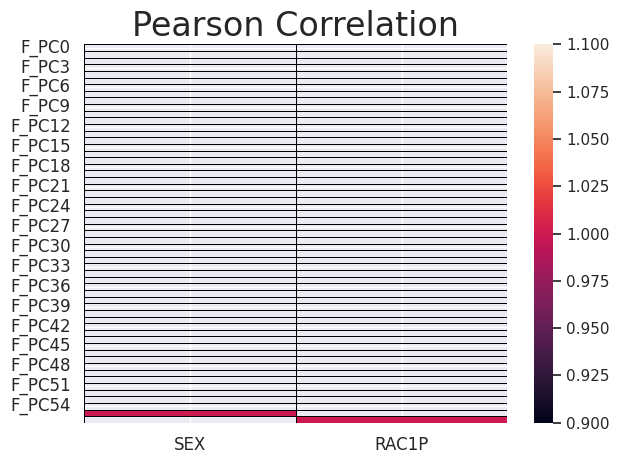

In [70]:
heatmap_filtered_relevant(task_3_merged.corr(method='pearson')[
                          ['SEX', 'RAC1P']], p_values[['SEX', 'RAC1P']], corrected_alpha, 'Pearson Correlation')


#### Part 4

In [71]:
X_prim_pca, U, _Z = fair_pca(X_test, group_test)
X_prim_pca.shape
# project back

X_test_fair_pca_proj_back = np.dot(X_prim_pca, U.T)
rec_errors = X_test - X_test_fair_pca_proj_back
rec_errors


array([[ 3.75788593e-02,  2.67483556e-01, -8.20731411e-03, ...,
         1.07119283e-02,  1.59285762e-02,  7.35536747e-04],
       [ 1.94737926e-02,  1.18815027e-01, -1.12787004e-02, ...,
         2.88328778e-03,  7.45034811e-03,  1.43479114e-04],
       [-2.97323147e-02, -4.63020767e-02,  6.51632400e-02, ...,
         1.38028047e-02, -5.88838372e-03,  1.40291476e-03],
       ...,
       [ 3.63063544e-02,  2.57310928e-01, -8.32507955e-03, ...,
         1.01989491e-02,  1.53439159e-02,  6.97243325e-04],
       [ 3.93301654e-02,  3.53709309e-01,  1.75849242e-02, ...,
         2.11502216e-02,  1.96663928e-02,  1.65534041e-03],
       [ 3.30796952e-02,  1.25104313e-01, -4.63854268e-02, ...,
        -5.44070258e-03,  9.53987729e-03, -6.77384879e-04]])

In [72]:
rec_errors_fair_pd = pd.DataFrame(
    rec_errors, columns=features_normalized.columns)
rec_errors_fair_pd


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Husband/wife,RELP_Institutionalized group quarters population,RELP_Noninstitutionalized group quarters population,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter
0,0.037579,0.267484,-0.008207,0.340980,-0.256105,0.053332,-0.297633,0.144287,0.127938,-0.112774,...,-0.130002,0.023652,-0.004481,0.013790,-0.018890,-0.000262,0.119368,0.010712,0.015929,0.000736
1,0.019474,0.118815,-0.011279,0.159496,-0.110003,0.011821,-0.147597,0.071126,0.069276,-0.054337,...,-0.038265,0.003987,-0.010064,0.005676,-0.011105,0.000151,0.063271,0.002883,0.007450,0.000143
2,-0.029732,-0.046302,0.065163,-0.126115,0.012950,0.089880,0.180037,-0.083724,-0.126088,0.054953,...,-0.140180,0.050346,0.068193,0.001366,0.025938,-0.002184,-0.106242,0.013803,-0.005888,0.001403
3,-0.006220,0.303953,0.124932,0.246160,-0.357122,0.269359,-0.067525,0.040220,-0.073547,-0.053522,...,-0.490380,0.141542,0.136906,0.023574,0.026278,-0.004993,-0.044608,0.045150,0.011505,0.004059
4,0.040120,0.359493,0.017470,0.428273,-0.358232,0.115992,-0.342552,0.167651,0.125472,-0.135725,...,-0.247459,0.056129,0.024120,0.020211,-0.015253,-0.001348,0.122165,0.021397,0.020008,0.001673
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.002943,0.190069,0.059371,0.173667,-0.214085,0.139280,-0.080032,0.042434,-0.015413,-0.043892,...,-0.258788,0.072495,0.065777,0.013637,0.009764,-0.002466,-0.002719,0.023628,0.008116,0.002088
19996,-0.008947,0.200895,0.095844,0.148728,-0.242570,0.198667,-0.017872,0.014351,-0.070252,-0.027998,...,-0.357985,0.104886,0.104523,0.016362,0.022088,-0.003764,-0.047301,0.033102,0.006952,0.003001
19997,0.036306,0.257311,-0.008325,0.328464,-0.246153,0.050635,-0.287180,0.139195,0.123773,-0.108725,...,-0.123960,0.022385,-0.004766,0.013240,-0.018325,-0.000237,0.115406,0.010199,0.015344,0.000697
19998,0.039330,0.353709,0.017585,0.420966,-0.352663,0.114742,-0.336242,0.164589,0.122807,-0.133321,...,-0.244488,0.055564,0.024151,0.019909,-0.014867,-0.001340,0.119668,0.021150,0.019666,0.001655


In [73]:
task_4_merged = pd.concat(
    [rec_errors_fair_pd.reset_index(), group_test.reset_index()], axis=1)
task_4_merged = task_4_merged.drop(["index"], axis=1)
task_4_merged


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Noninstitutionalized group quarters population,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,SEX,RAC1P
0,0.037579,0.267484,-0.008207,0.340980,-0.256105,0.053332,-0.297633,0.144287,0.127938,-0.112774,...,-0.004481,0.013790,-0.018890,-0.000262,0.119368,0.010712,0.015929,0.000736,2,1
1,0.019474,0.118815,-0.011279,0.159496,-0.110003,0.011821,-0.147597,0.071126,0.069276,-0.054337,...,-0.010064,0.005676,-0.011105,0.000151,0.063271,0.002883,0.007450,0.000143,1,1
2,-0.029732,-0.046302,0.065163,-0.126115,0.012950,0.089880,0.180037,-0.083724,-0.126088,0.054953,...,0.068193,0.001366,0.025938,-0.002184,-0.106242,0.013803,-0.005888,0.001403,1,1
3,-0.006220,0.303953,0.124932,0.246160,-0.357122,0.269359,-0.067525,0.040220,-0.073547,-0.053522,...,0.136906,0.023574,0.026278,-0.004993,-0.044608,0.045150,0.011505,0.004059,1,1
4,0.040120,0.359493,0.017470,0.428273,-0.358232,0.115992,-0.342552,0.167651,0.125472,-0.135725,...,0.024120,0.020211,-0.015253,-0.001348,0.122165,0.021397,0.020008,0.001673,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.002943,0.190069,0.059371,0.173667,-0.214085,0.139280,-0.080032,0.042434,-0.015413,-0.043892,...,0.065777,0.013637,0.009764,-0.002466,-0.002719,0.023628,0.008116,0.002088,2,1
19996,-0.008947,0.200895,0.095844,0.148728,-0.242570,0.198667,-0.017872,0.014351,-0.070252,-0.027998,...,0.104523,0.016362,0.022088,-0.003764,-0.047301,0.033102,0.006952,0.003001,1,1
19997,0.036306,0.257311,-0.008325,0.328464,-0.246153,0.050635,-0.287180,0.139195,0.123773,-0.108725,...,-0.004766,0.013240,-0.018325,-0.000237,0.115406,0.010199,0.015344,0.000697,1,1
19998,0.039330,0.353709,0.017585,0.420966,-0.352663,0.114742,-0.336242,0.164589,0.122807,-0.133321,...,0.024151,0.019909,-0.014867,-0.001340,0.119668,0.021150,0.019666,0.001655,1,1


In [74]:
group1_rec_error = task_4_merged.loc[task_4_merged["SEX"] == 1].mean().mean()
group2_rec_error = task_4_merged.loc[task_4_merged["SEX"] == 2].mean().mean()
group3_rec_error = task_4_merged.loc[task_4_merged["RAC1P"] == 1].mean().mean()
group4_rec_error = task_4_merged.loc[task_4_merged["RAC1P"] == 2].mean().mean()


In [75]:
print(f"Group 1 reconstruction error mean: {group1_rec_error}")
print(f"Group 2 reconstruction error mean: {group2_rec_error}")
print(f"Group 3 reconstruction error mean: {group3_rec_error}")
print(f"Group 4 reconstruction error mean: {group4_rec_error}")


Group 1 reconstruction error mean: 0.04089362329004934
Group 2 reconstruction error mean: 0.05631939111544379
Group 3 reconstruction error mean: 0.04692456967026864
Group 4 reconstruction error mean: 0.06381686034940817


### Task 2.5

In [76]:
X_test_fair_pca, _, _ = fair_pca(X_test, group_test)
X_test_fair_pca  # 52 fair PCA components, they suggested using only first 30
# X_test_fair_pca is without protected groups


array([[ 1.78329875e+00,  3.77656385e-01,  1.23165960e-01, ...,
         8.59002479e-03,  5.08770639e-03, -1.05521628e-02],
       [ 1.46128269e+00,  7.57999044e-01,  7.26190444e-01, ...,
        -6.65453165e-03, -1.92818619e-02, -1.81972650e-02],
       [ 1.28366636e+00, -1.84856444e-02, -2.48898717e-01, ...,
        -4.31510449e-04,  5.09923869e-03,  1.08583799e-02],
       ...,
       [ 1.68759455e+00,  3.54322542e-01,  9.28528118e-02, ...,
        -1.68512773e-03, -2.34377895e-03, -1.77832579e-03],
       [ 1.73931201e+00,  2.66496042e-01,  3.88523537e-01, ...,
        -1.54434184e-03, -4.76416738e-03, -1.40941291e-03],
       [ 1.62004943e+00,  8.05624147e-01,  1.83407161e-01, ...,
         4.26443756e-03,  4.27576897e-03, -4.98373866e-03]])

In [77]:
group_test


,SEX,RAC1P
72476,2,1
108056,1,1
128094,1,1
46044,1,1
42380,1,1
...,...,...
78970,2,1
53318,1,1
89865,1,1
103333,1,1
